# Introduction

Stock Index funds are a convenient and efficient way to invest one's savings. But what percentage should be invested? Common approaches vary from the 60/40 rule (i.e. 60% in stocks, 40% in bonds) to putting everything in stocks minus an emergency fund.

The <a href="https://en.wikipedia.org/wiki/Kelly_criterion">Kelly criterion </a>
 provides a systematic way to think about this problem. It suggests that the proportion allocated to stocks should be equal to

<center> $\gamma \times \frac{\langle X \rangle}{\text{var}(X)} $ <center>

where $\langle X \rangle$ is our annual expected return above the risk-free rate, $\text{var}(X)$ is the variance of the return and $\gamma$ is a parameter that measures the risk-appetite of the investor. A 'full-Kelly' investor has $\gamma =1$, a 'half-Kelly' investor has $\gamma = 0.5$ and so on.

In this notebook we study investment strategies based on the Kelly criterion for a portfolio composed of the S&P 500 and 10 year US Treasury Notes over a 30 year period. The S&P 500 constitutes the risky asset in the formula above (i.e. X) and the 10 year Treasury Note will be the riskless asset.

We estimate the annual returns of the S&P500 with the Cyclically Adjusted Price to Earnings Ratio (<a href="https://en.wikipedia.org/wiki/Cyclically_adjusted_price-to-earnings_ratio">CAPE</a>). We use the <a href="https://en.wikipedia.org/wiki/VIX">VIX</a> to estimate the S&P 500 variance. We used yahoo to download the datasets for the S&P500 and the VIX. We downloaded the CAPE dataset from Prof. Robert Schiller's <a href="http://www.econ.yale.edu/~shiller/data.htm">website</a>.

Our conclusions can be summarized from the following plot:

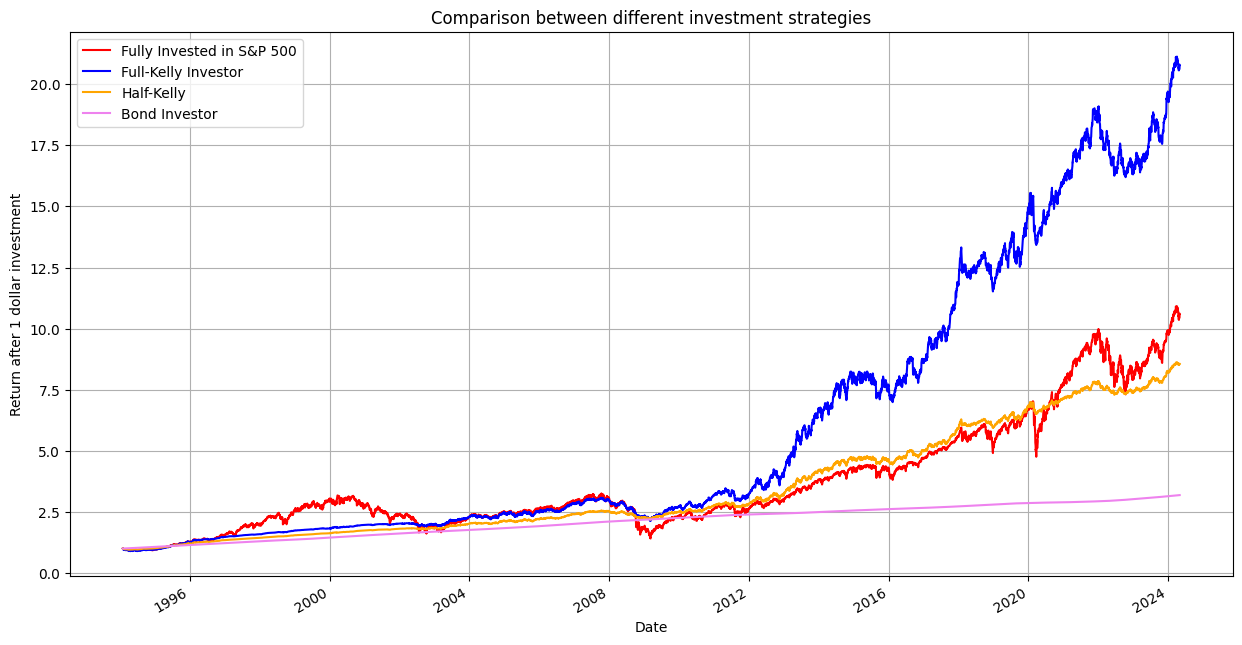
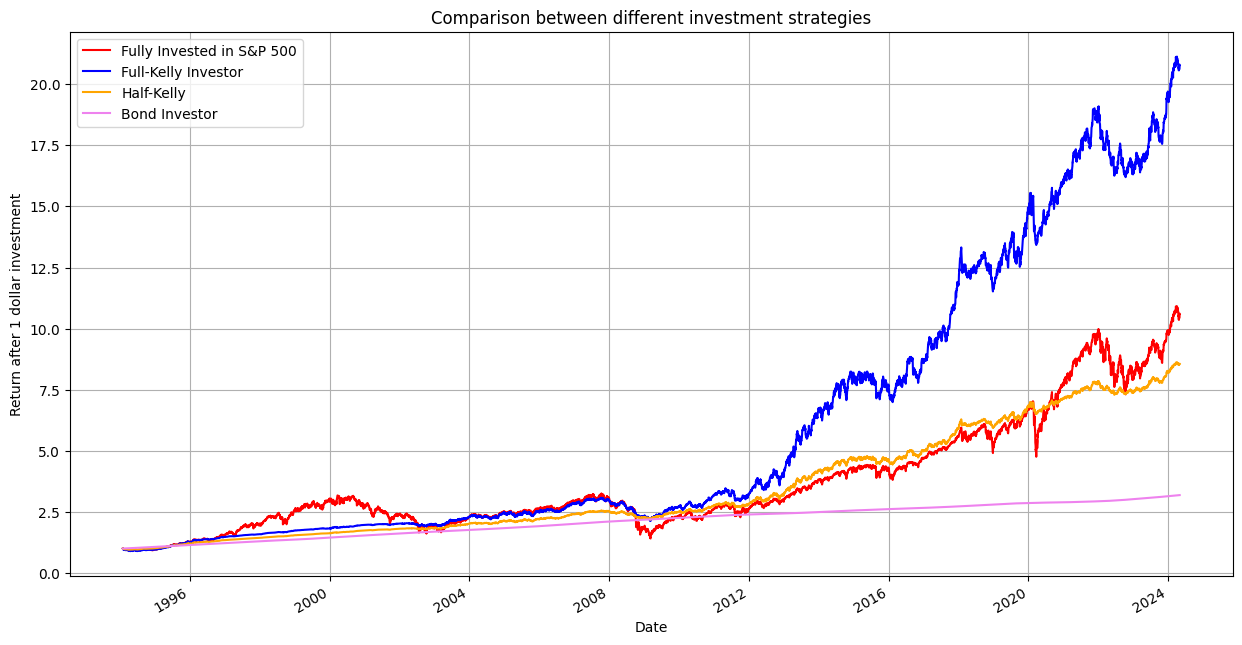
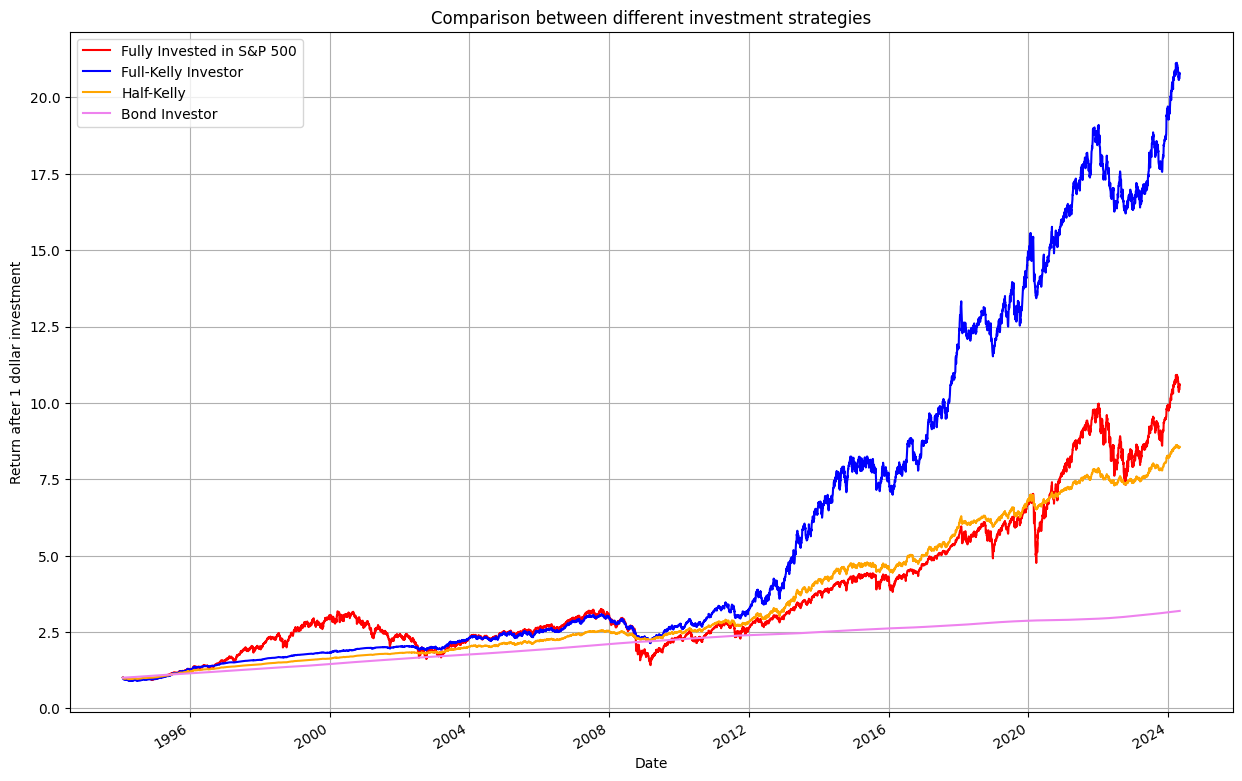
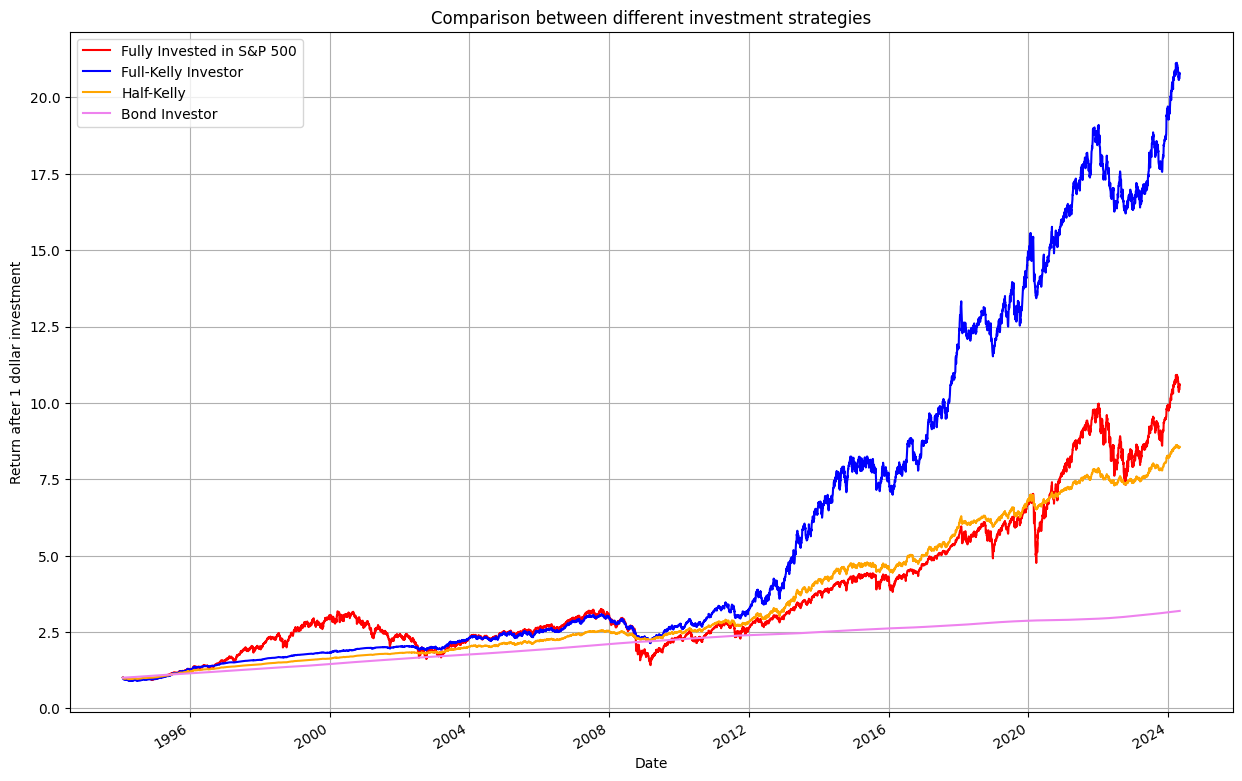

The Full-Kelly investor has several attractive features:
1. it is not affected by the dot-com bubble of the late 1990s, early 2000s
2. it is less impacted by the Great Financial Crisis of 2008 than the investor who puts 100% on the S&P 500
3. it greatly benefits from the bull run for the 2010s due to being highly leveraged

See the book <a href="https://www.amazon.co.uk/Missing-Billionaires-Better-Financial-Decisions/dp/1119747910">The Missing Billionaires</a> for a discussion of these ideas.

# Import Libraries

In [1]:
#pip install yfinance #need to restart after installing
import numpy as np # 
import pandas as pd 
import yfinance

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cape-s-and-p-500/Schiller.csv


# Import datasets

We import the S&P 500, the VIX and the yield on 10 year Treasury Notes from Yahoo. We import the monthly CAPE values from Prof. Robert Schiller's website.

In [2]:
s_and_p_index = yfinance.download (tickers = "^GSPC", start = "1994-02-01", 
                              end = "2024-05-01", interval = "1d")
vix_index = yfinance.download (tickers = "^VIX", start = "1994-02-01", 
                              end = "2024-05-01", interval = "1d")
schiller = pd.read_csv('/kaggle/input/cape-s-and-p-500/Schiller.csv')
yield_10_year_treasury_note_index = yfinance.download (tickers = "^TNX", start = "1994-02-01", 
                              end = "2024-05-01", interval = "1d")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Data Preparation

After importing the data, we organise it so as to have at our disposal over a 30 year period: 
1. S&P 500,
2. VIX
3. CAPE
4. annualized yield of 10 year treasury notes

(the cells in this section contain glue code and can be safely skipped by the reader)

In [3]:
def convert_percentage_float(percentage):
    if isinstance(percentage, str):
        return float(percentage[:(-2)])*0.01
    return percentage
schiller['Excess_CAPE_Yield'] = schiller['Excess_CAPE_Yield'].apply(convert_percentage_float)

In [4]:
def add_0(word):
    if len(word)==6:
        return word + '0'
    return word
CAPE_dict = schiller[['Date', 'Excess_CAPE_Yield']].set_index('Date').to_dict()
CAPE_dict = {add_0(str(key).replace('.',"-")) : value for key, value in CAPE_dict['Excess_CAPE_Yield'].items()}

In [5]:
def turn_key_into_value_from_dict(key, dict_):
    for key1, value in dict_.items():
        if key1 in key:
            return value
    return np.nan    

In [6]:
df = s_and_p_index.copy()
df['Excess_CAPE_Yield'] = df.index.astype(str).str[:10].map(lambda date: turn_key_into_value_from_dict(date, CAPE_dict))
df.rename(columns={'Open' : 'S_and_P'}, inplace = True)
df['VIX'] = vix_index['Open']
df['yield_10_year_treasury_note'] = yield_10_year_treasury_note_index['Open']
df['yield_10_year_treasury_note'] = df['yield_10_year_treasury_note'].ffill()
df = df.drop(['Low', 'High', 'Close', 'Adj Close', 'Volume'], axis=1)


# Dataframe with S&P 500, VIX, CAPE, 10 year treasury note yield

In [7]:
df

,S_and_P,Excess_CAPE_Yield,VIX,yield_10_year_treasury_note
Date,,,,
1994-02-01,481.600006,0.023,10.81,5.651
1994-02-02,479.619995,0.023,10.54,5.715
1994-02-03,481.959991,0.023,10.63,5.724
1994-02-04,480.679993,0.023,10.71,5.771
1994-02-07,469.809998,0.023,15.25,5.884
...,...,...,...,...
2024-04-24,5084.859863,0.013,15.76,4.642
2024-04-25,5019.879883,0.013,16.25,4.658
2024-04-26,5084.649902,0.013,15.49,4.686


# Merton Share

### The Merton Share *x* of a random variable *X* is equal to 

$x = \frac{\mathbb{E}(X)}{\text{var}(X)}$

where 
1. $\mathbb{E}(X)$ is the expectation value of X
2. $\text{var}(X)$ is the variance of X

We take X = (S & P annual rate of return) - (risk free rate of return ) . We estimate:  
1. $\mathbb{E}(X) = \text{Excess CAPE yield}$
2. $\text{var}(X) = \frac{\text{VIX}}{100}$

In [8]:
df['Merton_Share'] = df['Excess_CAPE_Yield']/((df['VIX']/100)**2)

<Axes: title={'center': 'Percentage of Portfolio Invested in S&P 500 according to Full Kelly Criterion'}, xlabel='Date'>

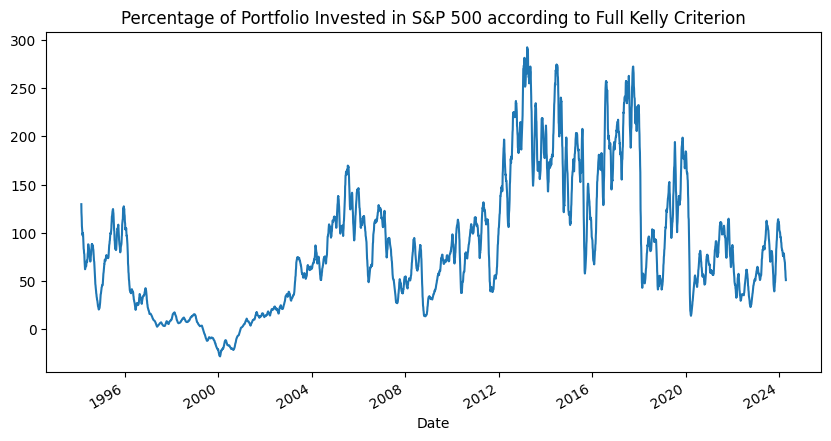

In [9]:
moving_average = (df['Merton_Share']*100).rolling(window=22, center=True).mean()
moving_average.plot(figsize = (10, 5), title = 'Percentage of Portfolio Invested in S&P 500 according to Full Kelly Criterion')

From this graph we see that the full-Kelly investor:
1. is very cautious during the Dot-com bubble years
2. is mildly cautious during the period preceding the Great Financial Crisis of 2008 and also during the early 2020's
3. is very leveraged during the bullrun of 2012 to 2020 (with a gap around 2018, 2019)

# Comparison between different investment strategies

We examine different investment strategies over a 30 year period starting in 1994. We assume that in 1994 we invest 1$ and afterwards our portfolio's value evolves according to the following rule:

\begin{align}
\frac{\text{value of portfolio at next business day}}{\text{value of portfolio at current business day}} &= \gamma \times \text{Merton Share} \times \frac{\text{S\&P 500 at next business day}}{\text{S\&P 500 at current business day}} \nonumber \\
&+ (1 - \text{Merton Share}) \times (1 + r) \times \frac{\Delta}{365} \nonumber
\end{align}

where $r$ is the annualised interest rate on a given day, $\Delta$ is the number of days between consecutive business days.

$\gamma$ is a parameter that measures the investor's risk appetite:
1. gamma= 1 $\iff$ full Kelly (risky)
2. gamma = 0.5 $\iff$ half Kelly (mild risk)
3. gamma = 0 $\iff$ Bond Investor (no risk)

We compare these three strategies with an investor who is 100% invested in the S&P 500.

In [10]:
df['Fully_Invested_S_and_P'] = df['S_and_P']/df['S_and_P'].iloc[0]
df['Full_Kelly'] = 1.0
df['Half_Kelly'] = 1.0
df['Bond_Investor'] = 1.0
ind_s_and_p = df.columns.get_loc('S_and_P')
ind_10_year_treasury_note = df.columns.get_loc('yield_10_year_treasury_note')
ind_merton_share= df.columns.get_loc('Merton_Share')
ind_Full_Kelly= df.columns.get_loc('Full_Kelly')
ind_Half_Kelly= df.columns.get_loc('Half_Kelly')
ind_Bond_Investor= df.columns.get_loc('Bond_Investor')
indx = [ind_Full_Kelly, ind_Half_Kelly, ind_Bond_Investor]
gammas = [1.0, 0.5, 0.0]
for ind, gamma in zip(indx, gammas):
    for i in range(1,len(df)):
        df.iloc[i, ind] = df.iloc[i-1, ind]*(gamma*df.iloc[i-1, ind_merton_share]
                                    *df.iloc[i, ind_s_and_p]/df.iloc[i-1,ind_s_and_p] +(1-gamma * df.iloc[i-1, ind_merton_share])*(
                                        1+df.iloc[i, ind_10_year_treasury_note]*0.01/365.0*((df.index[i] -df.index[i-1]).days)))

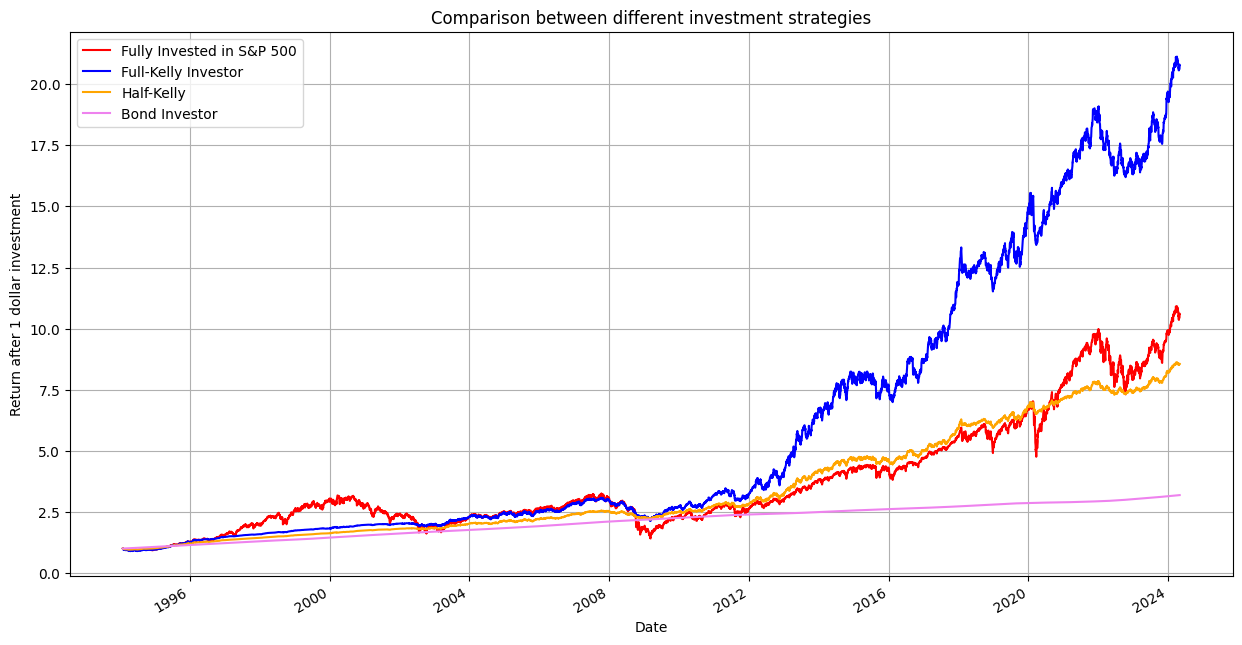

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,8))
df['Fully_Invested_S_and_P'].plot(ax=ax, label='Fully Invested in S&P 500', color='red')
df['Full_Kelly'].plot(ax=ax, label='Full-Kelly Investor', color='blue')
df['Half_Kelly'].plot(ax=ax, label='Half-Kelly', color='orange')
df['Bond_Investor'].plot(ax=ax, label='Bond Investor', color='violet')
ax.legend()
ax.set_title('Comparison between different investment strategies')
ax.set_ylabel('Return after 1 dollar investment')
ax.grid(True)
plt.show()